In [1]:
from __future__ import print_function
import os
import pickle

import numpy
from data import get_test_loader
import time
import numpy as np
from vocab import Vocabulary  # NOQA
import torch
from model import VSE, order_sim
from collections import OrderedDict
from glob import glob

from tqdm.autonotebook import tqdm

from evaluation import encode_data

import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
torch.cuda.is_available()

True

In [ ]:
#model_path="data/runs/coco_vse++/model_best.pth.tar"
model_path="data/runs/coco_vse++_resnet_restval/model_best.pth.tar"
image_path="/home/vu48pok/.data/compling/data/corpora/external/MSCOCO/COCO/val2014/"
data_path="data/"
vocab_path="vocab/"
split="test"
on_gpu=True

In [5]:
beam_files = glob('caps_files/beam*_reformat.json')
files_2d = glob('caps_files/*2d*_reformat.json')
files_4d = glob('caps_files/*4d*_reformat.json')
files_9d = glob('caps_files/*9d*_reformat.json')

In [6]:
device = 'cpu' if not on_gpu else 'cuda'
checkpoint = torch.load(model_path, map_location=torch.device(device))
opt = checkpoint['opt']
opt

Namespace(Diters=5, Gimage_size=32, Giters=1, batch_size=128, beta1=0.9, beta2=0.999, betas=(0.9, 0.999), clamp_lower=-0.01, clamp_upper=0.01, cnn_type='resnet152', crop_size=224, data_name='coco', embed_size=1024, eta=1.0, eta_m=1.0, finetune=False, gamma=0.1, grad_clip=2.0, img_dim=4096, learning_rate=0.0002, log_step=10, logger_name='runs/coco_uvs_resnet_restval_l2norm', lr_update=15, margin=0.2, max_violation=True, measure='cosine', model_name='UVS', model_path='./model/', ndf=64, no_imgnorm=False, no_prel2norm=False, noadam=False, nol2norm=False, num_epochs=30, num_layers=1, resume='', save_step=1000, txt_dim=6000, use_abs=False, use_mask=False, use_restval=True, val_step=500, vocab_path='./data/', vocab_size=11755, word_dim=300, workers=10)

In [7]:
if data_path is not None:
    opt.data_path = data_path

if vocab_path is not None:
    opt.vocab_path = vocab_path

# load vocabulary used by the model
with open(os.path.join(opt.vocab_path,
                       '%s_vocab.pkl' % opt.data_name), 'rb') as f:
    vocab = pickle.load(f)
opt.vocab_size = len(vocab)

# construct model
model = VSE(opt)

# load model state
model.load_state_dict(checkpoint['model'])

=> using pre-trained model 'resnet152'


In [29]:
def evaluate_file(caption_file, cluster_file, model=model, vocab=vocab, image_path=image_path, opt=opt):
    
    # read cluster file
    with open(cluster_file, 'rb') as f:
        clusters = pickle.load(f)
        n_dist = len(clusters[0])
        
    # read caption file to make sure the image ids align with the cluster targets
    with open(caption_file, 'r') as f:
        data = json.load(f)
        img_ids = [i['image_id'] for i in data['annotations']]
        assert [i[0] for i in clusters] == img_ids
    
    # initialize dataloader with captions from caption_file
    data_loader = get_test_loader(split, opt.data_name, vocab, opt.crop_size,
                              opt.batch_size, opt.workers, opt, 
                              image_location=image_path,
                              caption_file=caption_file
                             )
    
    print('Computing results...')
    # embed images and captions in a joint space
    img_embs, cap_embs = encode_data(model, data_loader, on_gpu=on_gpu)
    print('Images: %d, Captions: %d' %
          (img_embs.shape[0], cap_embs.shape[0]))
    
    # create df containing ordered image ids
    ann_df = pd.DataFrame(data_loader.dataset.coco[0].anns).T.set_index('id')

    # create dicts to align index positions and image ids
    idx2imgid = ann_df['image_id'].to_dict()
    imgid2idx = {v: k for k, v in idx2imgid.items()}

    # initialize empty array with shape [5000, n_dist] (where n_dist in [2, 4, 9])
    all_ranks = np.zeros((len(cap_embs), n_dist))
    
    # iterate through range from 0-4999
    for i in range(len(cap_embs)):
        # get caption embedding for current index
        cemb = cap_embs[i]
        # get target image id for current index
        target = ann_df.loc[i].image_id
        # get image cluster where target is the first image
        cluster = [j for j in clusters if j[0] == target][0]
        assert target == cluster[0]
        
        # get indices from cluster image ids
        idx_array = np.array([imgid2idx[j] for j in cluster])
        # get image embeddings for cluster entries
        iemb = img_embs[idx_array]

        # get cosine similarity between current caption embedding and all image embeddings
        cosines = np.zeros((len(iemb), 1))
        for j in range(len(iemb)):
            cosines[j] = cosine_similarity(cemb.reshape(1, -1), iemb[j].reshape(1, -1))
        # get ranks by sorting the cosines (in descending order)
        ranks = np.argsort(cosines.ravel())[::-1]
        
        #dots = cemb @ iemb.T
        # sort indices according to dot product
        #ranks = np.argsort(dots.ravel())[::-1]
        # add to all_ranks array
        all_ranks[i] = ranks

    # determine how often the target image is ranked first
    target_positions = np.where(all_ranks==0)[1]
    # compute accuracy
    acc = len(target_positions[target_positions == 0]) / len(target_positions)
    
    return acc, all_ranks, target_positions

In [30]:
cluster_file = 'caps_files/image_clusters/image_clusters_val_3.pkl'
results_2d = dict()
for file in tqdm(beam_files + files_2d):
    key = os.path.split(file)[-1].replace('_reformat.json', '')
    print(key)
    
    acc, all_ranks, target_positions = evaluate_file(file, cluster_file, model, vocab)
    
    results_2d[key] = {'acc': acc, 'all_ranks': all_ranks, 'target_positions': target_positions}

beam_char
loading annotations into memory...
0:00:00.059905
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
beam
loading annotations into memory...
0:00:00.057676
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_2d_l0-3_char
loading annotations into memory...
0:00:00.058010
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_2d_l0-3
loading annotations into memory...
0:00:00.057748
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_2d_l0-5_char
loading annotations into memory...
0:00:00.056598
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_2d_l0-5
loading annotations into memory...
0:00:00.058747
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_2d_l0-7_char
loading annotations into memory...
0:00:00.058594
creating index...
index created!

In [31]:
cluster_file = 'caps_files/image_clusters/image_clusters_val_5.pkl'
results_4d = dict()
for file in tqdm(beam_files + files_4d):
    key = os.path.split(file)[-1].replace('_reformat.json', '')
    print(key)
    
    acc, all_ranks, target_positions = evaluate_file(file, cluster_file, model, vocab)
    
    results_4d[key] = {'acc': acc, 'all_ranks': all_ranks, 'target_positions': target_positions}

beam_char
loading annotations into memory...
0:00:00.061225
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
beam
loading annotations into memory...
0:00:00.056551
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_4d_l0-3_char
loading annotations into memory...
0:00:00.102379
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_4d_l0-3
loading annotations into memory...
0:00:00.058198
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_4d_l0-5_char
loading annotations into memory...
0:00:00.058268
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_4d_l0-5
loading annotations into memory...
0:00:00.104072
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_4d_l0-7_char
loading annotations into memory...
0:00:00.057998
creating index...
index created!

In [32]:
cluster_file = 'caps_files/image_clusters/image_clusters_val_10.pkl'
results_9d = dict()
for file in tqdm(beam_files + files_9d):
    key = os.path.split(file)[-1].replace('_reformat.json', '')
    print(key)
    
    acc, all_ranks, target_positions = evaluate_file(file, cluster_file, model, vocab)
    
    results_9d[key] = {'acc': acc, 'all_ranks': all_ranks, 'target_positions': target_positions}

beam_char
loading annotations into memory...
0:00:00.060302
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
beam
loading annotations into memory...
0:00:00.054947
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_9d_l0-3_char
loading annotations into memory...
0:00:00.105953
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_9d_l0-3
loading annotations into memory...
0:00:00.058716
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_9d_l0-5_char
loading annotations into memory...
0:00:00.058370
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_9d_l0-5
loading annotations into memory...
0:00:00.058612
creating index...
index created!
Computing results...
Images: 5000, Captions: 5000
disc_beam_9d_l0-7_char
loading annotations into memory...
0:00:00.058672
creating index...
index created!

In [33]:
import re

def get_lambda(s):
    match = re.search(r'_l\d-\d',s)
    if match:
        d = match.group()[2:].replace('-', '.')
        return float(d)
    else:
        return None
def get_rationality(s):
    match = re.search(r'_r\d-\d',s)
    if match:
        d = match.group()[2:].replace('-', '.')
        return float(d)
    else:
        return None

def get_n_distractors(s):
    match = re.search(r'_\dd',s)
    if match:
        d = match.group()[1:-1].replace('-', '.')
        return int(d)
    else:
        return None
    
def get_segmentation(s):
    if s.endswith('char'):
        return 'char'
    else:
        return 'word'
    
def get_method(s):
    if s.startswith('beam'):
        return 'beam'
    elif s.startswith('rsa'):
        return 'rsa'
    elif s.startswith('disc_fuse_beam'):
        return 'disc_fuse_beam'
    elif s.startswith('disc_beam'):
        return 'disc_beam'

In [34]:
accs_2d = pd.DataFrame(results_2d).T[['acc']]
accs_4d = pd.DataFrame(results_4d).T[['acc']]
accs_9d = pd.DataFrame(results_9d).T[['acc']]

In [35]:
accs_2d['_lambda'] = accs_2d.index.map(get_lambda)
accs_2d['rationality'] = accs_2d.index.map(get_rationality)
accs_2d['method'] = accs_2d.index.map(get_method)
accs_2d['segmentation'] = accs_2d.index.map(get_segmentation)
accs_2d['n_distractors'] = 2

accs_4d['_lambda'] = accs_4d.index.map(get_lambda)
accs_4d['rationality'] = accs_4d.index.map(get_rationality)
accs_4d['method'] = accs_4d.index.map(get_method)
accs_4d['segmentation'] = accs_4d.index.map(get_segmentation)
accs_4d['n_distractors'] = 4

accs_9d['_lambda'] = accs_9d.index.map(get_lambda)
accs_9d['rationality'] = accs_9d.index.map(get_rationality)
accs_9d['method'] = accs_9d.index.map(get_method)
accs_9d['segmentation'] = accs_9d.index.map(get_segmentation)
accs_9d['n_distractors'] = 9

In [36]:
pd.concat([accs_2d, accs_4d, accs_9d]).to_csv('vsepp_accs.csv')

word


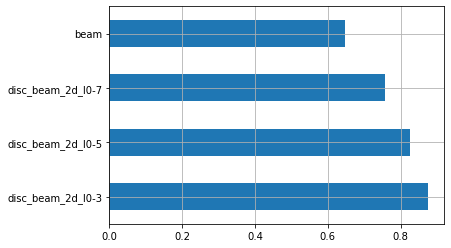

char


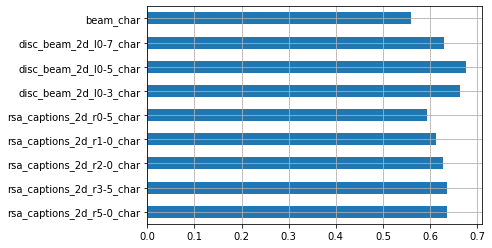

In [37]:
for seg in ['word', 'char']:
    print(seg)
    
    accs_2d.loc[accs_2d.segmentation == seg].loc[accs_2d.method.isin(['beam', 'rsa', 'disc_beam'])].sort_values(
        ['segmentation', 'method', '_lambda', 'rationality'],
        ascending=[True, False, True, False]
    ).acc.plot(kind='barh', grid=True)
    
    plt.show()

word


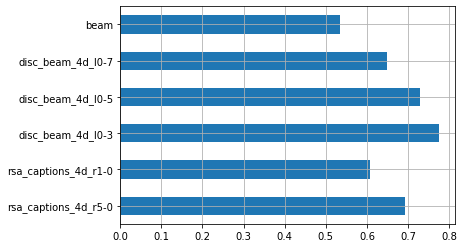

char


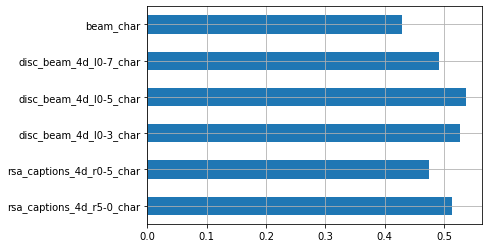

In [38]:
for seg in ['word', 'char']:
    print(seg)
    accs_4d.loc[accs_4d.segmentation == seg].loc[accs_4d.method.isin(['beam', 'rsa', 'disc_beam'])].sort_values(
        ['segmentation', 'method', '_lambda', 'rationality'],
        ascending=[True, False, True, False]
    ).acc.plot(kind='barh', grid=True)
    plt.show()

word


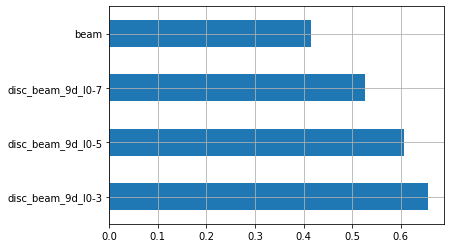

char


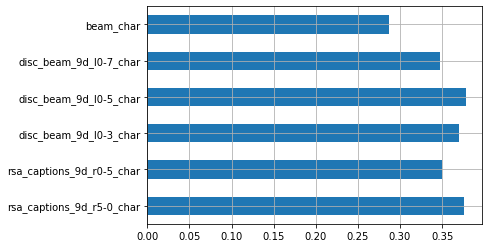

In [39]:
for seg in ['word', 'char']:
    print(seg)
    accs_9d.loc[accs_9d.segmentation == seg].loc[accs_9d.method.isin(['beam', 'rsa', 'disc_beam'])].sort_values(
        ['segmentation', 'method', '_lambda', 'rationality'],
        ascending=[True, False, True, False]
    ).acc.plot(kind='barh', grid=True)
    plt.show()